## PyTorch/TPU MNIST Demo

This colab example corresponds to the implementation under [test_train_mp_mnist.py](https://github.com/pytorch/xla/blob/master/test/test_train_mp_mnist.py).

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [ ]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

### If you're using GPU with this colab notebook, run the below commented code to install GPU compatible PyTorch wheel and dependencies

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp38-cp38-linux_x86_64.whl --force-reinstall 

### Only run the below commented cell if you would like a nightly release

In [ ]:
# VERSION = "1.13"  #@param ["1.13", "nightly", "20220315"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os 
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

In [ ]:
#@title PSGD code
"""Created in May, 2018
Pytorch functions for preconditioned SGD
@author: XILIN LI, lixilinx@gmail.com

Updated in Dec, 2020: 
Wrapped Kronecker product preconditioner for easy use: the code will select the proper Kronecker product  
preconditioner based on the formats of input left and right preconditioners.
Add torch.jit.script decorator by default
"""

import torch


###############################################################################
@torch.jit.script
def update_precond_dense(Q, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, List[Tensor], List[Tensor], float, float) -> Tensor
    """
    update dense preconditioner P = Q^T*Q
    Q: Cholesky factor of preconditioner with positive diagonal entries 
    dxs: list of perturbations of parameters
    dgs: list of perturbations of gradients
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs])
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs])
    
    a = Q.mm(dg)
    #b = torch.triangular_solve(dx, Q, upper=True, transpose=True)[0]
    b = torch.linalg.solve_triangular(Q.t(), dx, upper=False)

    grad = torch.triu(a.mm(a.t()) - b.mm(b.t()))
    step0 = step/(grad.abs().max() + _tiny)        
        
    return Q - step0*grad.mm(Q)

@torch.jit.script
def precond_grad_dense(Q, grads):
    # type: (Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient using dense preconditioner
    Q: Cholesky factor of preconditioner
    grads: list of gradients
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads]
    lens = [g.shape[0] for g in grad]
    grad = torch.cat(grad)
    grad = Q.t().mm(Q.mm(grad))
    
    pre_grads = []
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]
        
    return pre_grads


###############################################################################
def update_precond_kron(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    """
    Update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right update rule.
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero 
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _update_precond_dense_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==2: # (dense, normalization) format
            return _update_precond_norm_dense(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==1: # (dense, scaling) format
            return _update_precond_dense_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _update_precond_norm_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==1: # (normalization, scaling) format
            return _update_precond_norm_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _update_precond_dense_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==2: # (scaling, normalization) format
            return _update_precond_norm_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')
 
       
def precond_grad_kron(Ql, Qr, Grad):
    """
    return preconditioned gradient using Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right way to precondition the gradient
    Grad: (matrix) gradient
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _precond_grad_dense_dense(Ql, Qr, Grad)
        elif p==2: # (dense, normalization) format
            return _precond_grad_norm_dense(Qr, Ql, Grad.t()).t()
        elif p==1: # (dense, scaling) format
            return _precond_grad_dense_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _precond_grad_norm_dense(Ql, Qr, Grad)
        elif p==1: # (normalization, scaling) format
            return _precond_grad_norm_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _precond_grad_dense_scale(Qr, Ql, Grad.t()).t()
        elif p==2: # (scaling, normalization) format
            return _precond_grad_norm_scale(Qr, Ql, Grad.t()).t()
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')
        

###############################################################################
@torch.jit.script
def _update_precond_dense_dense(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Ql: (left side) Cholesky factor of preconditioner with positive diagonal entries
    Qr: (right side) Cholesky factor of preconditioner with positive diagonal entries
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(torch.diag(Qr))
    
    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    Qr *= rho
    
    #A = Ql.mm( dG.mm( Qr.t() ) )
    #Bt = torch.triangular_solve((torch.triangular_solve(dX.t(), Qr, upper=True, transpose=True))[0].t(), 
    #                 Ql, upper=True, transpose=True)[0]
    A = torch.linalg.multi_dot([Ql, dG, Qr.t()])
    Bt = torch.linalg.solve_triangular(Ql.t(), torch.linalg.solve_triangular(Qr, dX, upper=True, left=False), upper=False)
    
    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))
    
    step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
        
    return Ql - step1*grad1.mm(Ql), Qr - step2*grad2.mm(Qr)
    
@torch.jit.script
def _precond_grad_dense_dense(Ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using Kronecker product preconditioner
    Ql: (left side) Cholesky factor of preconditioner
    Qr: (right side) Cholesky factor of preconditioner
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad, Qr.t(), Qr)
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad, Qr.t(), Qr])
    

###############################################################################
# (normalization, dense) format Kronecker product preconditioner
@torch.jit.script
def _update_precond_norm_dense(ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, dense) Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    Qr has shape (N, N)
    ql[0] is the diagonal part of Ql
    ql[1,0:-1] is the last column of Ql, excluding the last entry
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero  
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(torch.diag(Qr))  
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    Qr *= rho
    
    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG 
    A = A.mm(Qr.t())
    
    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    #Bt = torch.triangular_solve(Bt.t(), Qr, upper=True, transpose=True)[0].t()
    Bt = torch.linalg.solve_triangular(Qr, Bt, upper=True, left=False)
    
    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t()) 
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])  

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)), 
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)
    
    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    
    return torch.stack((new_ql0, new_ql1)), Qr - step2*grad2.mm(Qr)

@torch.jit.script
def _precond_grad_norm_dense(ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, dense) Kronecker product preconditioner 
    Suppose Grad has shape (M, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    Qr: shape (N, N), Cholesky factor of right preconditioner
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad 
    #preG = torch.chain_matmul(preG, Qr.t(), Qr)
    preG = torch.linalg.multi_dot([preG, Qr.t(), Qr])
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row
    
    return preG


###############################################################################
# (normalization, scaling) Kronecker product preconditioner 
# the left one is a normalization preconditioner; the right one is a scaling preconditioner
@torch.jit.script
def _update_precond_norm_scale(ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    qr has shape (1, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero  
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(qr) # qr always is positive
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    qr *= rho
    
    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG 
    A *= qr # Ql*dG*Qr 
    
    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    Bt /= qr # Ql^(-T)*dX*Qr^(-1) 
    
    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t()) 
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])  

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)), 
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)
    
    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    
    return torch.stack((new_ql0, new_ql1)), qr - step2*grad2*qr

@torch.jit.script
def _precond_grad_norm_scale(ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    ql has shape (2, M) 
    qr has shape (1, N) 
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad 
    preG *= (qr*qr) # Ql*Grad*Qr^T*Qr
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row
    
    return preG


###############################################################################
@torch.jit.script
def _update_precond_dense_scale(Ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (dense, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    Ql has shape (M, M)
    qr has shape (1, N)
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero 
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(qr)
    
    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    qr *= rho
    
    A = Ql.mm( dG*qr )
    #Bt = torch.triangular_solve(dX/qr, Ql, upper=True, transpose=True)[0]
    Bt = torch.linalg.solve_triangular(Ql.t(), dX/qr, upper=False)
    
    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)
    
    step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
        
    return Ql - step1*grad1.mm(Ql), qr - step2*grad2*qr
    
@torch.jit.script
def _precond_grad_dense_scale(Ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (dense, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    Ql: shape (M, M), (left side) Cholesky factor of preconditioner
    qr: shape (1, N), defines a diagonal matrix for output feature scaling
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad*(qr*qr))
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad*(qr*qr)])



###############################################################################   
@torch.jit.script                     
def update_precond_splu(L12, l3, U12, u3, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor],List[Tensor], float,float) -> Tuple[Tensor,Tensor,Tensor,Tensor]
    """
    update sparse LU preconditioner P = Q^T*Q, where 
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    dxs: a list of random perturbation on parameters
    dgs: a list of resultant perturbation on gradients
    step: update step size normalized to range [0, 1] 
    _tiny: an offset to avoid division by zero 
    """
    # make sure that L and U have similar dynamic range
    max_l = torch.max(torch.max(torch.diag(L12)), torch.max(l3))
    max_u = torch.max(torch.max(torch.diag(U12)), torch.max(u3))
    rho = torch.sqrt(max_l/max_u)
    L12 /= rho
    l3 /= rho
    U12 *= rho
    u3 *= rho
    
    # extract the blocks
    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]
    
    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs]) # a tall column vector
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs]) # a tall column vector
    
    # U*dg
    Ug1 = U1.mm(dg[:r]) + U2.mm(dg[r:])
    Ug2 = u3*dg[r:]
    # Q*dg
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # inv(U^T)*dx
    #iUtx1 = torch.triangular_solve(dx[:r], U1, upper=True, transpose=True)[0]
    iUtx1 = torch.linalg.solve_triangular(U1.t(), dx[:r], upper=False)
    iUtx2 = (dx[r:] - U2.t().mm(iUtx1))/u3
    # inv(Q^T)*dx
    iQtx2 = iUtx2/l3
    #iQtx1 = torch.triangular_solve(iUtx1 - L2.t().mm(iQtx2), L1, upper=False, transpose=True)[0]
    iQtx1 = torch.linalg.solve_triangular(L1.t(), iUtx1 - L2.t().mm(iQtx2), upper=True)
    # L^T*Q*dg
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*dg
    Pg1 = U1.t().mm(LtQg1)
    Pg2 = U2.t().mm(LtQg1) + u3*LtQg2
    # inv(L)*inv(Q^T)*dx
    #iLiQtx1 = torch.triangular_solve(iQtx1, L1, upper=False)[0]
    iLiQtx1 = torch.linalg.solve_triangular(L1, iQtx1, upper=False)
    iLiQtx2 = (iQtx2 - L2.mm(iLiQtx1))/l3
    # inv(P)*dx
    iPx2 = iLiQtx2/u3
    #iPx1 = torch.triangular_solve(iLiQtx1 - U2.mm(iPx2), U1, upper=True)[0]
    iPx1 = torch.linalg.solve_triangular(U1, iLiQtx1 - U2.mm(iPx2), upper=True)
    
    # update L
    grad1 = Qg1.mm(Qg1.t()) - iQtx1.mm(iQtx1.t())
    grad1 = torch.tril(grad1)
    grad2 = Qg2.mm(Qg1.t()) - iQtx2.mm(iQtx1.t())
    grad3 = Qg2*Qg2 - iQtx2*iQtx2
    max_abs_grad = torch.max(torch.abs(grad1))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    step0 = step/(max_abs_grad + _tiny)
    newL1 = L1 - step0*grad1.mm(L1)
    newL2 = L2 - step0*grad2.mm(L1) - step0*grad3*L2
    newl3 = l3 - step0*grad3*l3

    # update U
    grad1 = Pg1.mm(dg[:r].t()) - dx[:r].mm(iPx1.t())
    grad1 = torch.triu(grad1)
    grad2 = Pg1.mm(dg[r:].t()) - dx[:r].mm(iPx2.t())
    grad3 = Pg2*dg[r:] - dx[r:]*iPx2
    max_abs_grad = torch.max(torch.abs(grad1))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    step0 = step/(max_abs_grad + _tiny)
    newU1 = U1 - U1.mm(step0*grad1)
    newU2 = U2 - U1.mm(step0*grad2) - step0*grad3.t()*U2
    newu3 = u3 - step0*grad3*u3

    return torch.cat([newL1, newL2], dim=0), newl3, torch.cat([newU1, newU2], dim=1), newu3

@torch.jit.script
def precond_grad_splu(L12, l3, U12, u3, grads):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient with sparse LU preconditioner
    where P = Q^T*Q, 
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    grads: a list of gradients to be preconditioned
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads] # a list of column vector
    lens = [g.shape[0] for g in grad] # length of each column vector
    grad = torch.cat(grad)  # a tall column vector
    
    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]    
    
    # U*g
    Ug1 = U1.mm(grad[:r]) + U2.mm(grad[r:])
    Ug2 = u3*grad[r:]
    # Q*g
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # L^T*Q*g
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*g
    pre_grad = torch.cat([U1.t().mm(LtQg1),
                          U2.t().mm(LtQg1) + u3*LtQg2])
    
    pre_grads = [] # restore pre_grad to its original shapes
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(pre_grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]
    
    return pre_grads



##############################################################################
#
# The low-rank approximation (UVd) preconditioner is defined by
#
#   Q = (I + U*V')*diag(d)
#
# which, after reparameterization, is equivalent to form
#
#   diag(d) + U*V'
# 
# It relates to the LM-BFGS and conjugate gradient methods. 
#
# The JIT decorator can be enabled if helps. 
# 

#@torch.jit.script
def IpUVtmatvec(U, V, x):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Returns (I + U*V')*x. All variables are either matrices or column vectors. 
    """
    return x + U.mm(V.t().mm(x))

# def IpUVtsolve(U, V, x):
#     """
#     Returns inv(I + U*V')*x. All variables are either matrices or column vectors.
#     """
#     VtU = V.t().mm(U)
#     I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
#     return x - U.mm(torch.linalg.solve(I + VtU, V.t().mm(x))) # torch.solve is slow

# def norm_UVt(U, V):
#     """
#     Returns ||U*V'||_fro = sqrt(tr(U'*U*V'*V)) = sqrt(sum((U'*U)*(V'*V))) 
#     """
#     return torch.sqrt(torch.abs(torch.sum( (U.t().mm(U))*(V.t().mm(V)) )))

#@torch.jit.script
def update_precond_UVd_math_(U, V, d, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = (I + U*V')*diag(d) with (vector, Hessian-vector product) = (v, h).
    State variables U, V and d are updated inplace. 
                               
    U, V, d, v, and h are either matrices or column vectors.  
    """
    # balance the numerical dynamic ranges of U and V; optional 
    if torch.rand([]) < 0.01:
        normU = torch.linalg.vector_norm(U)
        normV = torch.linalg.vector_norm(V)
        rho = torch.sqrt(normU/normV)
        U.div_(rho)
        V.mul_(rho)

    Qh = IpUVtmatvec(U, V, d*h)
    Ph = d*IpUVtmatvec(V, U, Qh)
    
    # invQtv = IpUVtsolve(V, U, v/d)
    # invPv = IpUVtsolve(U, V, invQtv)/d
    VtU = V.t().mm(U)
    I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
    IpVtU = I + VtU
    invQtv = v/d
    # torch's linalg.solve is slow for small matrix
    invQtv = invQtv - V.mm(torch.linalg.solve(IpVtU.t(), U.t().mm(invQtv)))  
    invPv  = invQtv - U.mm(torch.linalg.solve(IpVtU,     V.t().mm(invQtv)))
    invPv = invPv/d

    nablaD = Ph*h - v*invPv
    mu = step/(torch.max(torch.abs(nablaD)) + tiny)
    #d = d - mu*d*nablaD
    d.sub_(mu*d*nablaD)
    
    # update either U or V, not both at the same time
    a, b = Qh, invQtv
    if torch.rand([]) < 0.5:
        # nablaU = Qh.mm(Qh.t().mm(V)) - invQtv.mm(invQtv.t().mm(V))
        # mu = step/(norm_UVt(nablaU, V) + _tiny)
        # U = U - mu*(nablaU + nablaU.mm(V.t().mm(U)))
        atV = a.t().mm(V)
        atVVt = atV.mm(V.t())
        btV = b.t().mm(V)
        btVVt = btV.mm(V.t())
        norm = torch.sqrt(torch.abs( (a.t().mm(a))*(atVVt.mm(atVVt.t())) # abs to avoid sqrt(-0.0) 
                                    +(b.t().mm(b))*(btVVt.mm(btVVt.t())) 
                                  -2*(a.t().mm(b))*(atVVt.mm(btVVt.t())) ))
        mu = step/(norm + tiny)
        # U = U - mu*( a.mm(atV.mm(IpVtU)) 
        #             -b.mm(btV.mm(IpVtU)) )
        U.sub_(mu*( a.mm(atV.mm(IpVtU)) 
                   -b.mm(btV.mm(IpVtU)) ))
    else:
        # nablaV = Qh.mm(Qh.t().mm(U)) - invQtv.mm(invQtv.t().mm(U))
        # mu = step/(norm_UVt(U, nablaV) + _tiny)
        # V = V - mu*(nablaV + V.mm(U.t().mm(nablaV)))
        atU = a.t().mm(U)
        btU = b.t().mm(U)
        UUta = U.mm(atU.t())
        UUtb = U.mm(btU.t())
        norm = torch.sqrt(torch.abs( (UUta.t().mm(UUta))*(a.t().mm(a)) # abs to avoid sqrt(-0.0)
                                    +(UUtb.t().mm(UUtb))*(b.t().mm(b))
                                  -2*(UUta.t().mm(UUtb))*(a.t().mm(b)) ))
        mu = step/(norm + tiny)
        # V = V - mu*( (a + V.mm(atU.t())).mm(atU) 
        #             -(b + V.mm(btU.t())).mm(btU) )
        V.sub_(mu*( (a + V.mm(atU.t())).mm(atU) 
                   -(b + V.mm(btU.t())).mm(btU) ))

    # return [U, V, d]

#@torch.jit.script
def precond_grad_UVd_math(U, V, d, g):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = (I + U*V')*diag(d).
                                         
    All variables here are either matrices or column vectors. 
    """
    g = IpUVtmatvec(U, V, d*g)
    g = d*IpUVtmatvec(V, U, g)
    return g


class UVd:
    """
    Implements the low-rank approximation (UVd) preconditioner, Q = (I + U*V')*diag(d), as a class.

    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        rank_of_approximation: rank of approximation, i.e., rank of U or V;
        preconditioner_init_scale: initial scale of Q, or roughly, Q = preconditioner_init_scale*eye();
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via finite-difference formulae.

    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite-difference formulae by setting 
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs, 
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same state, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.
        
        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized. 

        Note 3: `torch.linalg.solve' is called twice in function `update_precond_UVd_math_'.
        Certain solver could be orders of magnitude faster than others, especially for small matrices (see the pdf file).
        Considering replace it with faster ones if the default solver is too slow.

        Note 4: Currently, no support of sparse and mixed-precision gradients. 
        Half precision is supported except that torch.linalg.solve (v1.12) requires casting float16 to float32.    
        
        Note 5: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, and 
        exact_hessian_vector_product (bool) all can be reset on the fly. 
    """
    def __init__(self,  params_with_grad, rank_of_approximation:int=10, preconditioner_init_scale=1.0,
                        lr_params=0.01, lr_preconditioner=0.01, momentum=0.0,
                        grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                        exact_hessian_vector_product:bool=True):
        # mutable members
        self.lr_params = lr_params
        self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        # protected members
        params_with_grad = [params_with_grad,] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad] # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps**0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        self._U = torch.randn(num_params, rank_of_approximation, dtype=dtype, device=device) / (num_params*rank_of_approximation)**0.5
        self._V = torch.randn(num_params, rank_of_approximation, dtype=dtype, device=device) / (num_params*rank_of_approximation)**0.5
        self._d = torch.ones( num_params, 1, dtype=dtype, device=device) * preconditioner_init_scale
        self._m = None # momentum buffer 


    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with low-rank approximation (UVd) preconditioner, i.e., 
        updating the trainable parameters once, and returning what closure returns.

        Args:
            closure (callable): a closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting 
                                from the same rng state if self.exact_hessian_vector_product = False; otherwise doesn't matter. 
        """
        if torch.rand([]) < self.preconditioner_update_probability:
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.flatten(v) for v in vs])
            h = torch.cat([torch.flatten(h) for h in Hvs])
            if self.exact_hessian_vector_product:
                update_precond_UVd_math_(self._U, self._V, self._d,
                                         v[:,None], h[:,None], step=self.lr_preconditioner, tiny=self._tiny)
            else: # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
                update_precond_UVd_math_(self._U, self._V, self._d,
                                         v[:,None]/self._delta_param_scale, h[:,None]/self._delta_param_scale, step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None # no vs and Hvs

        # preconditioned gradients; momentum is optional
        grad = torch.cat([torch.flatten(g) for g in grads])
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_((1 - self.momentum)*grad)
            pre_grad = precond_grad_UVd_math(self._U, self._V, self._d, self._m[:, None])
        else:
            self._m = None # clean the buffer when momentum is set to zero 
            pre_grad = precond_grad_UVd_math(self._U, self._V, self._d, grad[:, None])
            
        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm/grad_norm, 1.0)
            
        # update the parameters
        if self.exact_hessian_vector_product or (vs is None):
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param))
             for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]
        else: # in this case, do not forget to remove the perturbation on parameters
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param) + v)
             for (param, i, j, v) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes, vs)]
        # return whatever closure returns
        return closure_returns

################## end of UVd preconditioner #################################


##############################################################################
# An Xmat (X-matrix) preconditioner is defined by
#
#   Q = diag(a) + adiag(b)
#
# where adiag means anti-diagonal.
# It's slightly more complicated than a diagonal preconditioner, but performs better.
#

#@torch.jit.script
def update_precond_Xmat_math_(a, b, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> None
    """
    Update preconditioner Q = diag(a) + adiag(b) with (vector, Hessian-vector product) = (v, h).
    State variables a and b are updated inplace.
    """
    Qh = a*h + b*torch.flip(h, [0])
    aflip, bflip = torch.flip(a, [0]), torch.flip(b, [0])
    invQtv = (aflip*v - bflip*torch.flip(v, [0]))/(a*aflip - b*bflip)
    nablaA = Qh*Qh - invQtv*invQtv
    nablaB = Qh*torch.flip(Qh, [0]) - invQtv*torch.flip(invQtv, [0])
    q, r = divmod(len(nablaB), 2)
    if r == 1:
        nablaB[q] = 0

    mu = step/(torch.maximum(torch.max(torch.abs(nablaA)), torch.max(torch.abs(nablaB))) + tiny)
    a.sub_(mu*(nablaA*a + nablaB*bflip))
    b.sub_(mu*(nablaA*b + nablaB*aflip))

#@torch.jit.script
def precond_grad_Xmat_math(a, b, g):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = diag(a) + adiag(b).
    """
    ab = a * b
    return (a*a + torch.flip(b*b, [0]))*g + (ab + torch.flip(ab, [0]))*torch.flip(g, [0])

from torch.optim.optimizer import Optimizer
class XMat(Optimizer):
    """
    Implements the Xmat preconditioner, Q = diag(a) + adiag(b), as a class.
    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        preconditioner_init_scale: initial scale of Q, i.e., Q = preconditioner_init_scale*eye();
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via finite-difference formulae.
    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite-difference formulae by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same state, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.
        
        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.

        Note 3: Currently, no support of sparse and mixed-precision gradients.

        Note 4: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, and
        exact_hessian_vector_product (bool) all can be reset on the fly.
    """
    def __init__(self, params_with_grad, preconditioner_init_scale=1.0,
                 lr_params=0.01, lr_preconditioner=0.01, momentum=0.0, 
                 grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                 exact_hessian_vector_product: bool = True):
        # mutable members
        self.lr_params = lr_params
        self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        # protected members
        params_with_grad = [params_with_grad, ] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad]  # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps ** 0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        self._a = torch.ones(num_params, dtype=dtype, device=device)*preconditioner_init_scale
        self._b = torch.zeros(num_params, dtype=dtype, device=device)
        self._m = None # buffer for momentum 
        defaults = dict(lr=lr_params)
        super(XMat, self).__init__(self._params_with_grad, defaults)        

    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with Xmat preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.
        Args:
            closure (callable): a closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if self.exact_hessian_vector_product = False; otherwise doesn't matter.
        """
        if torch.rand([]) < self.preconditioner_update_probability:
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.flatten(v) for v in vs])
            h = torch.cat([torch.flatten(h) for h in Hvs])
            if self.exact_hessian_vector_product:
                update_precond_Xmat_math_(self._a, self._b,
                                         v, h, step=self.lr_preconditioner, tiny=self._tiny)
            else:  # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
                update_precond_Xmat_math_(self._a, self._b,
                                         v/self._delta_param_scale, h/self._delta_param_scale,
                                         step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None  # no vs and Hvs

        # preconditioned gradients; momentum is optional        
        grad = torch.cat([torch.flatten(g) for g in grads])
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_((1 - self.momentum)*grad)
            pre_grad = precond_grad_Xmat_math(self._a, self._b, self._m)
        else:
            self._m = None # clean the buffer when momentum is set to zero again 
            pre_grad = precond_grad_Xmat_math(self._a, self._b, grad)
        
        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm / grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None):
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param))
             for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]
        else:  # in this case, do not forget to remove the perturbation on parameters
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param) + v)
             for (param, i, j, v) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes, vs)]
        # return whatever closure returns
        return closure_returns

################## end of Xmat preconditioner #################################


###############################################################################
# The classic Newton–Raphson type preconditioner.
# Clearly, it is applicable only to small scale problems 
#

# @torch.jit.script
def update_precond_newton_math_(Q, v, h, step, tiny):
    # type: (Tensor, Tensor, Tensor, float, float) -> None
    """
    Update the classic Newton–Raphson type preconditioner P = Q'*Q with (v, h).
    """
    a = Q.mm(h)
    b = torch.linalg.solve_triangular(Q.t(), v, upper=False)
    grad = torch.triu(a.mm(a.t()) - b.mm(b.t()))
    mu = step/(grad.abs().max() + tiny)      
    Q.sub_(mu*grad.mm(Q))

class Newton:
    """
    Implements the classic Newton–Raphson type preconditioner for SGD as a class.
    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        preconditioner_init_scale: initial scale of Q, i.e., Q = preconditioner_init_scale*eye();
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via finite-difference formulae.
    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite-difference formulae by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same state, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.
        
        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.
        Note 3: Currently, no support of sparse and mixed-precision gradients.
        Note 4: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, and
        exact_hessian_vector_product (bool) all can be reset on the fly.
    """
    def __init__(self, params_with_grad, preconditioner_init_scale=1.0,
                 lr_params=0.01, lr_preconditioner=0.01, momentum=0.0, 
                 grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                 exact_hessian_vector_product: bool = True):
        # mutable members
        self.lr_params = lr_params
        self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        # protected members
        params_with_grad = [params_with_grad, ] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad]  # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps ** 0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        self._Q = torch.eye(num_params, dtype=dtype, device=device)*preconditioner_init_scale
        self._m = None # buffer for momentum 

    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with Newton–Raphson preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.
        Args:
            closure (callable): a closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if self.exact_hessian_vector_product = False; otherwise doesn't matter.
        """
        if torch.rand([]) < self.preconditioner_update_probability:
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.flatten(v) for v in vs])
            h = torch.cat([torch.flatten(h) for h in Hvs])
            if self.exact_hessian_vector_product:
                update_precond_newton_math_(self._Q,
                                            v[:,None], h[:,None], step=self.lr_preconditioner, tiny=self._tiny)
            else:  # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
                update_precond_newton_math_(self._Q,
                                            v[:,None]/self._delta_param_scale, h[:,None]/self._delta_param_scale,
                                            step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None  # no vs and Hvs

        # preconditioned gradients; momentum is optional        
        grad = torch.cat([torch.flatten(g) for g in grads])
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_((1 - self.momentum)*grad)
            pre_grad = self._Q.t() @ (self._Q @ self._m)
        else:
            self._m = None # clean the buffer when momentum is set to zero again 
            pre_grad = self._Q.t() @ (self._Q @ grad)
        
        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm / grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None):
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param))
             for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]
        else:  # in this case, do not forget to remove the perturbation on parameters
            [param.subtract_(lr * pre_grad[j - i:j].view_as(param) + v)
             for (param, i, j, v) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes, vs)]
        # return whatever closure returns
        return closure_returns

################## end of Newton–Raphson preconditioner #################################

### Define Parameters and Helpers, and start Training


In [ ]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [ ]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 2
FLAGS['learning_rate'] = 0.1
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [ ]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)
  
  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  optimizer = XMat(model.parameters(),lr_params=lr,momentum=0.9,preconditioner_update_probability=0.1)
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      output = model(data)
      loss = loss_fn(output, target)
      def closure():
          return loss
      # if using single TPU one can use mark_step after standatd optimizer.step(closure)
      #xm.mark_step()
      xm.optimizer_step(optimizer, optimizer_args={'closure':closure})
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

[xla:0](0) Loss=2.33622 Rate=360.25 GlobalRate=360.23 Time=Tue Mar 21 22:05:38 2023
[xla:2](0) Loss=2.36655 Rate=170.40 GlobalRate=170.39 Time=Tue Mar 21 22:05:40 2023
[xla:3](0) Loss=2.35576 Rate=77.56 GlobalRate=77.56 Time=Tue Mar 21 22:05:41 2023
[xla:4](0) Loss=2.38184 Rate=64.69 GlobalRate=64.69 Time=Tue Mar 21 22:05:42 2023
[xla:0](20) Loss=0.36951 Rate=519.97 GlobalRate=605.15 Time=Tue Mar 21 22:05:42 2023
[xla:1](0) Loss=2.36546 Rate=44.22 GlobalRate=44.22 Time=Tue Mar 21 22:05:43 2023
[xla:7](0) Loss=2.33757 Rate=36.86 GlobalRate=36.86 Time=Tue Mar 21 22:05:44 2023
[xla:6](0) Loss=2.39576 Rate=29.96 GlobalRate=29.96 Time=Tue Mar 21 22:05:46 2023
[xla:2](20) Loss=0.38797 Rate=241.12 GlobalRate=279.08 Time=Tue Mar 21 22:05:49 2023
[xla:5](0) Loss=2.35329 Rate=27.54 GlobalRate=27.54 Time=Tue Mar 21 22:05:50 2023
[xla:3](20) Loss=0.40883 Rate=162.62 GlobalRate=201.76 Time=Tue Mar 21 22:05:53 2023
[xla:4](20) Loss=0.19045 Rate=148.03 GlobalRate=184.71 Time=Tue Mar 21 22:05:54 2023


## Visualize Predictions

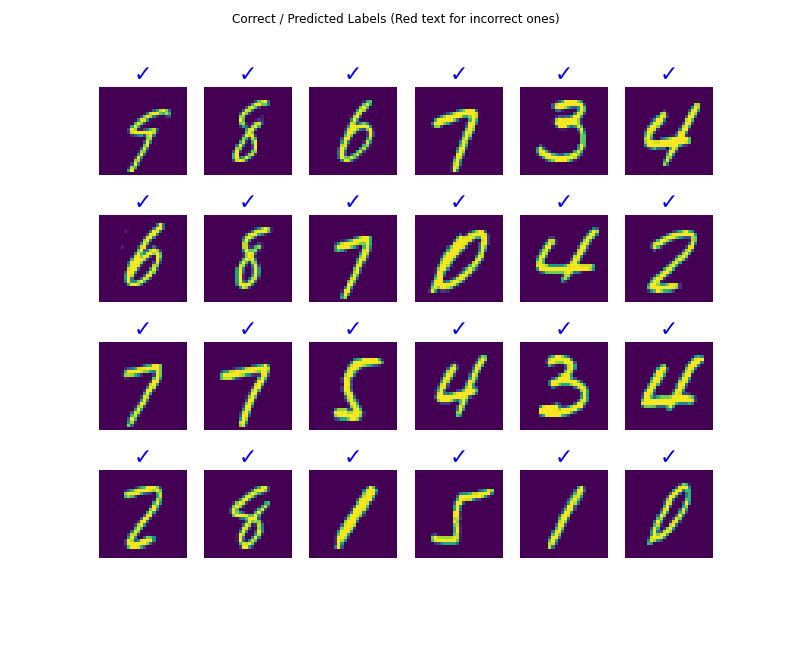

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)